# LangGraph Multi-Agent Yelp Navigator

An educational example of building a multi-agent system using LangGraph to create an intelligent Yelp business search assistant.

## What You'll Learn

- How to orchestrate multiple specialized agents working together
- How to implement conditional routing based on user needs
- How to integrate external tools and APIs into LangGraph workflows
- How to add quality control through a supervisor pattern

## Architecture

The system has **6 specialized agents**:

1. **Clarification Agent** - Extracts query, location, and detail level from user input
2. **Search Agent** - Finds businesses matching the criteria
3. **Details Agent** - Fetches additional info (websites, descriptions) - *optional*
4. **Sentiment Agent** - Analyzes customer reviews - *optional*
5. **Summary Agent** - Creates a user-friendly response
6. **Supervisor Agent** - Reviews quality and can request revisions

**Workflow:** User Query → Clarification → Search → [Details] → [Sentiment] → Summary → Approval → End

Agents in brackets are only called when the user needs that level of detail.

## Prerequisites

**Start Hayhooks server:**
```bash
cd yelp-navigator
uv run sh build_all_pipelines.sh && sh start_hayhooks.sh
```

**Create `.env` file:**
```
OPENAI_API_KEY=your_openai_api_key_here
OPENAI_API_KEY=your_rapidapi_key
```

- [Rapid API](https://rapidapi.com/beat-analytics-beat-analytics-default/api/yelp-business-reviews)

- [OpenAI](https://platform.openai.com/api-keys)

In [1]:
# =============================================================================
# STEP 1: Imports and Configuration
# =============================================================================

import os
import json
import requests
from typing import Annotated, Literal, TypedDict, List, Dict, Any
from operator import add

# LangGraph for building agent workflows
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent
from dotenv import load_dotenv

# Import custom agent logic from helper modules
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'langgraph-helpers'))
from langgraph_helpers.agents import clarification_agent, supervisor_approval_agent
from langgraph_helpers.nodes import search_agent_node, details_agent_node, sentiment_agent_node, summary_agent_node
from langgraph_helpers.tools import search_businesses, get_business_details, analyze_reviews_sentiment, set_base_url

load_dotenv(".env")

# Configure endpoints
BASE_URL = "http://localhost:1416"  # Hayhooks server
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

set_base_url(BASE_URL)

if not OPENAI_API_KEY:
    print("⚠️  Warning: OPENAI_API_KEY not set. Please add it to your .env file.")
else:
    print("✅ OpenAI API key configured")
    print(f"✅ Hayhooks server: {BASE_URL}")

✅ OpenAI API key configured
✅ Hayhooks server: http://localhost:1416


In [2]:
# =============================================================================
# STEP 2: Define Agent State
# =============================================================================
# AgentState is the "shared memory" for all agents in the workflow.
# Each agent reads from and writes to this state as the workflow progresses.

class AgentState(TypedDict):
    """State shared across all agents in the workflow."""
    
    # Conversation tracking
    messages: Annotated[List[BaseMessage], add]  # Full conversation history
    
    # User intent (set by Clarification Agent)
    user_query: str              # Original user question
    clarified_query: str         # What they're looking for (e.g., "Mexican restaurants")
    clarified_location: str      # Where to search (e.g., "Austin, Texas")
    detail_level: str            # "general", "detailed", or "reviews"
    
    # Workflow control
    clarification_complete: bool  # True when ready to proceed to search
    next_agent: str              # Which agent to call next (enables conditional routing)
    
    # Agent results
    agent_outputs: Dict[str, Any]  # Results from each agent (search, details, sentiment)
    
    # Final output
    final_summary: str  # User-friendly response
    
    # Quality control (for Supervisor Agent)
    approval_attempts: int      # How many times supervisor has reviewed (max 2)
    needs_revision: bool        # True if summary needs improvement
    revision_feedback: str      # What to improve

## Step 3: Initialize Language Model

In [3]:
# Initialize the LLM that will power our agents
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
# =============================================================================
# STEP 4: Create Agent Wrapper Functions
# =============================================================================
# Wrappers pass the LLM to agents that need it for reasoning

def clarification_agent_wrapper(state: AgentState) -> AgentState:
    """Extracts query, location, and detail level from user input."""
    return clarification_agent(state, llm)

def supervisor_approval_agent_wrapper(state: AgentState) -> AgentState:
    """Reviews summary quality and decides if revision is needed."""
    return supervisor_approval_agent(state, llm)

In [5]:
# Wrappers pass tools to agents that interact with external pipelines

def search_agent_wrapper(state: AgentState) -> AgentState:
    """Searches for businesses using the Hayhooks search pipeline."""
    return search_agent_node(state, search_businesses)

def details_agent_wrapper(state: AgentState) -> AgentState:
    """Fetches business details (website, description) via Hayhooks."""
    return details_agent_node(state, get_business_details)

def sentiment_agent_wrapper(state: AgentState) -> AgentState:
    """Analyzes review sentiment via Hayhooks sentiment pipeline."""
    return sentiment_agent_node(state, analyze_reviews_sentiment)

def summary_agent_wrapper(state: AgentState) -> AgentState:
    """Synthesizes all information into a user-friendly response."""
    return summary_agent_node(state, llm)

In [6]:
# =============================================================================
# STEP 5: Define Routing Logic and Build the Workflow
# =============================================================================

def route_after_clarification(state: AgentState) -> str:
    """Route to search if clarification is complete, otherwise loop back."""
    return "search" if state.get("clarification_complete", False) else "clarification"

def route_from_agents(state: AgentState) -> str:
    """Dynamic routing based on next_agent value set by each agent."""
    next_agent = state.get("next_agent", "end")
    return END if next_agent == "end" else next_agent

# Build the workflow graph
workflow = StateGraph(AgentState)

# Add all agent nodes
workflow.add_node("clarification", clarification_agent_wrapper)
workflow.add_node("search", search_agent_wrapper)
workflow.add_node("details", details_agent_wrapper)
workflow.add_node("sentiment", sentiment_agent_wrapper)
workflow.add_node("summary", summary_agent_wrapper)
workflow.add_node("supervisor_approval", supervisor_approval_agent_wrapper)

# Define workflow edges (how agents connect)
workflow.add_edge(START, "clarification")
workflow.add_conditional_edges("clarification", route_after_clarification, {"clarification": "clarification", "search": "search"})
workflow.add_conditional_edges("search", route_from_agents, {"details": "details", "sentiment": "sentiment", "summary": "summary", END: END})
workflow.add_conditional_edges("details", route_from_agents, {"sentiment": "sentiment", "summary": "summary", END: END})
workflow.add_conditional_edges("sentiment", route_from_agents, {"summary": "summary", END: END})
workflow.add_conditional_edges("summary", route_from_agents, {"supervisor_approval": "supervisor_approval", END: END})
workflow.add_conditional_edges("supervisor_approval", route_from_agents, {"search": "search", "details": "details", "sentiment": "sentiment", "summary": "summary", END: END})

# Compile the workflow
app = workflow.compile()
print("✅ Multi-agent workflow compiled and ready!")

✅ Multi-agent workflow compiled and ready!


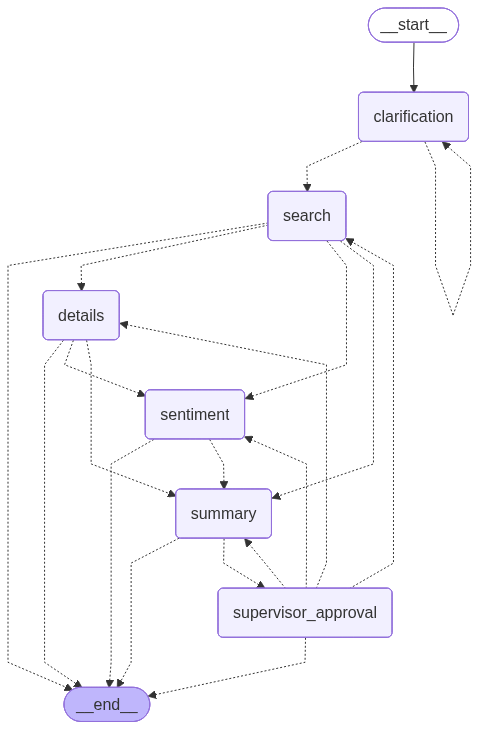

In [7]:
# Visualize the workflow graph
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(app.get_graph())

## Examples: Running the Multi-Agent System

Below are three examples showing different detail levels:
- **General**: Basic business info only
- **Detailed**: Includes websites and descriptions
- **Reviews**: Full analysis with sentiment

### Example 1: General Search

In [8]:
# Example 1: General search - basic business information only
result = app.invoke({
    "user_query": "Find me pizza places in Chicago",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 1: GENERAL SEARCH")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)


EXAMPLE 1: GENERAL SEARCH


Assistant:
CLARIFIED:
QUERY: pizza places
LOCATION: Chicago
DETAIL_LEVEL: general
--------------------------------------------------------------------------------

Assistant:
Found 240 businesses:
1. Anthony's Pizza Place - 3.0 stars (207 reviews)
2. Papa's Pizza Place - 4.4 stars (370 reviews)
3. Piece Brewery and Pizzeria - 4.0 stars (3921 reviews)
4. Giordano's - 3.8 stars (4226 reviews)
5. Pequod's Pizza - 3.9 stars (8785 reviews)
--------------------------------------------------------------------------------

Assistant:
SUMMARY:

If you're on the hunt for some delicious pizza in Chicago, you're in luck! The city is brimming with fantastic pizza places that cater to all tastes and preferences. Here are a few top recommendations to get you started on your pizza adventure.

First up, we have Papa's Pizza Place, which boasts an impressive 4.4-star rating from 370 reviews. It's a great spot if you're looking for a cozy atmosphere and some seriously tasty p

In [9]:
# Example 2: Detailed search - includes websites and business descriptions
result = app.invoke({
    "user_query": "Find me Italian restaurants in San Francisco. I need detailed information including their websites.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 2: DETAILED SEARCH")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)


EXAMPLE 2: DETAILED SEARCH


Assistant:
CLARIFIED:
QUERY: Italian restaurants
LOCATION: San Francisco
DETAIL_LEVEL: detailed
--------------------------------------------------------------------------------

Assistant:
Found 240 businesses:
1. Doppio Zero San Francisco - 4.0 stars (750 reviews)
2. Bella Trattoria - 4.3 stars (2065 reviews)
3. Bottega - 4.3 stars (1567 reviews)
4. Roma Antica - 4.5 stars (1808 reviews)
5. Bocconcino - 4.5 stars (214 reviews)
--------------------------------------------------------------------------------

Assistant:
Retrieved details for 0 businesses:

--------------------------------------------------------------------------------

Assistant:
SUMMARY:

San Francisco is a haven for Italian food lovers, offering a delightful array of restaurants that cater to every palate and budget. If you're in the mood for some authentic Italian cuisine, here are a few top recommendations to consider:

1. **Doppio Zero San Francisco**: With a solid 4.0-star rating fro

In [10]:
# Example 3: Full analysis with review sentiment
result = app.invoke({
    "user_query": "What are the best coffee shops in Portland, Oregon? I want to see customer reviews and what people are saying about them.",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 3: FULL ANALYSIS WITH REVIEWS")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)

# Show the final approved summary
if result.get("final_summary"):
    print("\n" + "#"*80)
    print("FINAL SUMMARY FOR THE USER:")
    print("#"*80)
    print(result["final_summary"])


EXAMPLE 3: FULL ANALYSIS WITH REVIEWS


Assistant:
CLARIFIED:
QUERY: coffee shops
LOCATION: Portland, Oregon
DETAIL_LEVEL: reviews
--------------------------------------------------------------------------------

Assistant:
Found 240 businesses:
1. Fizz N Sip - 4.8 stars (12 reviews)
2. La Lucha Coffee - 5.0 stars (18 reviews)
3. Cadejo Coffee - 4.9 stars (78 reviews)
4. Sincerely Bagel - 4.5 stars (41 reviews)
5. Stumptown Cafe - 4.6 stars (51 reviews)
--------------------------------------------------------------------------------

Assistant:
Retrieved details for 0 businesses:

--------------------------------------------------------------------------------

Assistant:
Analyzed 10 businesses:

1. Business 0AjjNqv7VZNFLjUBUsLGDQ: +10 =0 -0 (100% positive)
2. Business ynuac8PN67LZEL02U_Vv9g: +10 =0 -0 (100% positive)
3. Business o5EH9Bmd_rTi4TpSjef4Sw: +10 =0 -0 (100% positive)
--------------------------------------------------------------------------------

Assistant:
SUMMARY:

If y

In [11]:
# Quick test run with approval tracking
result = app.invoke({
    "user_query": "Find me Mexican restaurants in Austin with reviews",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False,
    "approval_attempts": 0
})

# Print conversation
for msg in result["messages"]:
    print(f"\n{msg.content}\n{'-'*60}")

# Show approval status
print(f"\n✓ Approval attempts: {result.get('approval_attempts', 0)}")
print(f"✓ Status: {'Approved' if result.get('next_agent') == 'end' else 'In Progress'}")


CLARIFIED:
QUERY: Mexican restaurants
LOCATION: Austin
DETAIL_LEVEL: reviews
------------------------------------------------------------

Found 240 businesses:
1. Austin Daily Press - 4.3 stars (345 reviews)
2. Austin Taco Project - 3.6 stars (621 reviews)
3. Birrieria Mama Rosa - 4.8 stars (32 reviews)
4. Fonda San Miguel - 4.1 stars (1322 reviews)
5. El Alma - 4.1 stars (1408 reviews)
------------------------------------------------------------

Retrieved details for 0 businesses:

------------------------------------------------------------

Analyzed 0 businesses:

------------------------------------------------------------

SUMMARY:

If you're on the hunt for some delicious Mexican food in Austin, you're in luck! The city is brimming with fantastic options that cater to all tastes and budgets. Let's dive into some top recommendations based on reviews.

First up, we have **Austin Daily Press**, boasting a solid 4.3 stars from 345 reviews. This spot is known for its tasty offering

## Key Features Summary

- **Clarification Agent**: Extracts query, location, detail level (with fallback defaults after 2 attempts)
- **Conditional Routing**: Details and sentiment agents only run when user needs that information
- **Tool Integration**: Each agent calls specific Haystack pipelines via Hayhooks
- **Quality Control**: Supervisor reviews summaries (max 2 approval attempts to prevent loops)
- **Flexible Detail Levels**: Supports `general`, `detailed`, or `reviews` workflows

## Next Steps

- Explore the `langgraph_helpers/` modules to see agent implementation details
- Try modifying the routing logic to add new agents or change workflow paths
- Experiment with different detail levels and observe how the workflow adapts